In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


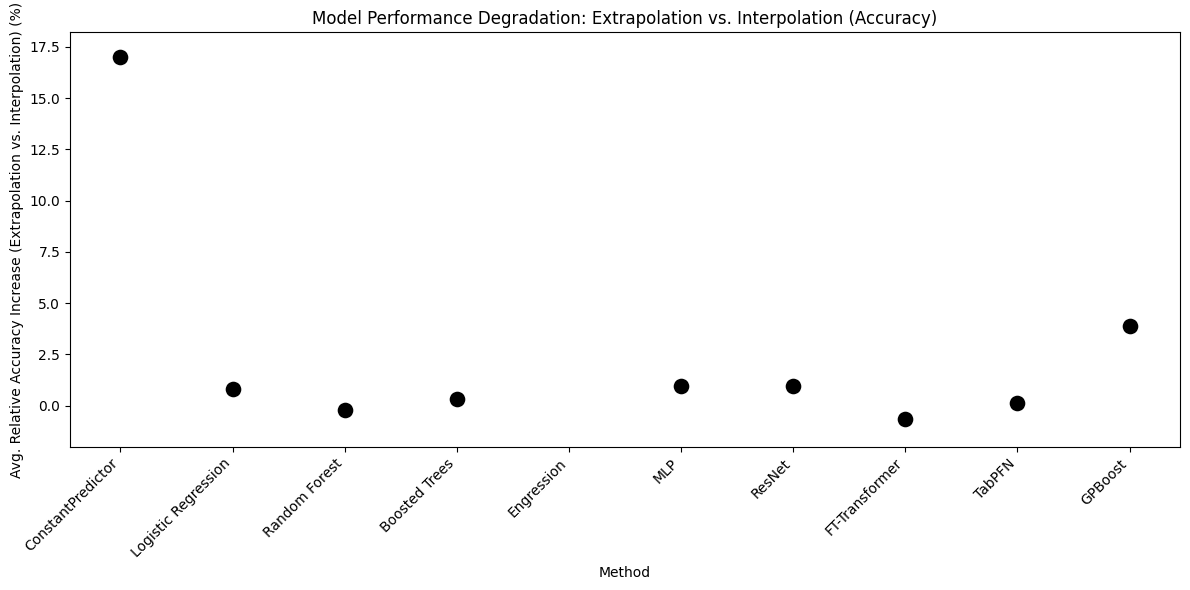

In [4]:
df = pd.read_csv("results_full.csv")
metric = "Accuracy"
df = df[df["metric"] == metric]

# 1. Separate interpolation (ip) and extrapolation (ep) data
df_ip = df[df['split_method'] == "random_split"].copy()
df_ep = df[df['split_method'] != "random_split"].copy()

df_ip_baseline = df_ip[['task_id', 'model', 'value']].rename(columns={'value': 'metric_ip'})


merged_df = pd.merge(df_ep, df_ip_baseline, on=['task_id', 'model'])

merged_df['relative_difference'] = ( merged_df['metric_ip'] - merged_df['value']) / merged_df['metric_ip'] 
overall = (
    merged_df
    .groupby('model')['relative_difference']
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100  # Convert to percentage

method_order = [
    'ConstantPredictor', 'LogisticRegressor',
    'RandomForestClassifier', 'RandomForestRegressor',
    'LGBMClassifier', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_Accuracy'
]

present_models = overall['model'].unique()
method_order_filtered = [m for m in method_order if m in present_models]
overall = overall.set_index('model').reindex(method_order_filtered).reset_index()

rename_map = {
   'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'LGBMRegressor':        'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':    'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_Accuracy': 'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

# 8. Create the plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=overall, x='Method', y='Mean', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Avg. Relative Accuracy Increase (Extrapolation vs. Interpolation) (%)')
plt.xlabel('Method')
plt.title('Model Performance Degradation: Extrapolation vs. Interpolation (Accuracy)')
plt.ylim(bottom=-2)  # A positive value means extrapolation error is higher
plt.tight_layout()

# Save the figure to a file
os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/ep_vs_ip_relative_difference_Accuracy.png', bbox_inches='tight')

plt.show()

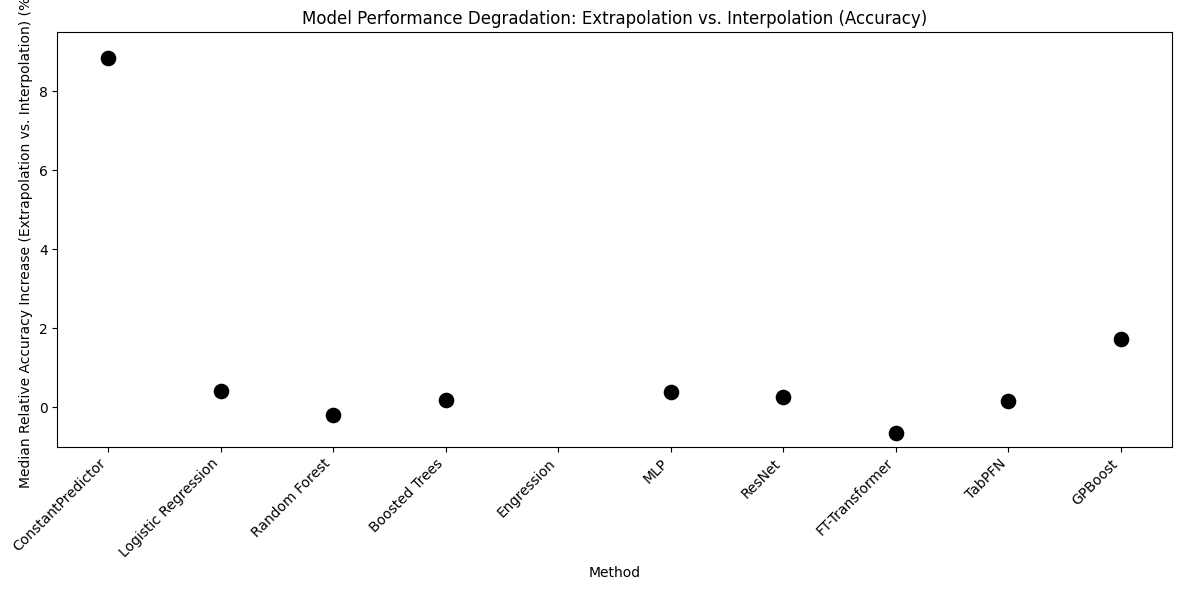

In [5]:

df = pd.read_csv("results_full.csv")
metric = "Accuracy"
df = df[df["metric"] == metric]

# 1. Separate interpolation (ip) and extrapolation (ep) data
df_ip = df[df['split_method'] == "random_split"].copy()
df_ep = df[df['split_method'] != "random_split"].copy()

df_ip_baseline = df_ip[['task_id', 'model', 'value']].rename(columns={'value': 'metric_ip'})


merged_df = pd.merge(df_ep, df_ip_baseline, on=['task_id', 'model'])

merged_df['relative_difference'] = (merged_df['metric_ip'] - merged_df['value']) / merged_df['metric_ip']

overall = (
    merged_df
    .groupby('model')['relative_difference']
    .median()
    .reset_index(name='Median')
)
overall['Median'] *= 100  # Convert to percentage

method_order = [
    'ConstantPredictor', 'LogisticRegressor',
    'RandomForestClassifier', 'RandomForestRegressor',
    'LGBMClassifier', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_Accuracy'
]

present_models = overall['model'].unique()
method_order_filtered = [m for m in method_order if m in present_models]
overall = overall.set_index('model').reindex(method_order_filtered).reset_index()

rename_map = {
    'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'LGBMRegressor':        'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':    'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_Accuracy': 'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

# 8. Create the plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=overall, x='Method', y='Median', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Median Relative Accuracy Increase (Extrapolation vs. Interpolation) (%)')
plt.xlabel('Method')
plt.title('Model Performance Degradation: Extrapolation vs. Interpolation (Accuracy)')
plt.ylim(bottom=-1)  # A positive value means extrapolation error is higher
plt.tight_layout()

# Save the figure to a file
os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/ep_vs_ip_relative_difference_median_Accuracy.png', bbox_inches='tight')

plt.show()